In [1]:
import numpy as np
import pandas as pd

from fastai import *
from fastai.vision import *

import imageio

import os

import matplotlib.pyplot as plt
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test.csv', 'sample_submission.csv', 'train.csv']


## Control Variables

In [2]:
root = Path('../input')
train_path = Path('train')
rseed = 7
val_size = 0.05

# Helper functions

In [3]:
def save_imgs(path:Path, data, labels):
    path.mkdir(parents=True,exist_ok=True)
    for label in np.unique(labels):
        (path/str(label)).mkdir(parents=True,exist_ok=True)
    for i in range(len(data)):
        if(len(labels)!=0):
            imageio.imsave( str( path/str(labels[i])/(str(i)+'.jpg') ), data[i] )
        else:
            imageio.imsave( str( path/(str(i)+'.jpg') ), data[i] )

# Load data

In [4]:
train_csv = pd.read_csv(root/'train.csv')

In [5]:
test_csv = pd.read_csv(root/'test.csv')

# Explore data

In [6]:
train_csv.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Prepare data

In [7]:
data_X, data_y = train_csv.loc[:,'pixel0':'pixel783'], train_csv['label']

In [8]:
from sklearn.model_selection import train_test_split

train_X, val_X, train_y, val_y = train_test_split(data_X, data_y, test_size=val_size,random_state=rseed,stratify=data_y)

In [9]:
def to_img_shape(data_X, data_y=[]):
    data_X = np.array(data_X).reshape(-1,28,28)
    data_X = np.stack((data_X,)*3, axis=-1)
    data_y = np.array(data_y)
    return data_X,data_y

In [10]:
train_X,train_y = to_img_shape(train_X, train_y)

In [11]:
val_X,val_y = to_img_shape(val_X,val_y)

Save images

In [12]:
save_imgs(Path('/data/train'),train_X,train_y)

In [13]:
save_imgs(Path('/data/valid'),val_X,val_y)

In [14]:
data = ImageDataBunch.from_folder('/data/',bs=256,size=28,ds_tfms=get_transforms(do_flip=False),num_workers=0).normalize(imagenet_stats)

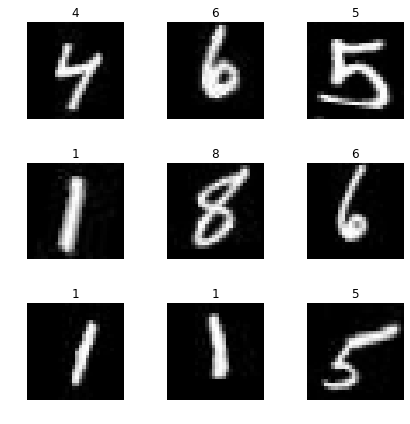

In [15]:
data.show_batch(3,figsize=(6,6))

# Train model

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:01<00:00, 34939416.37it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


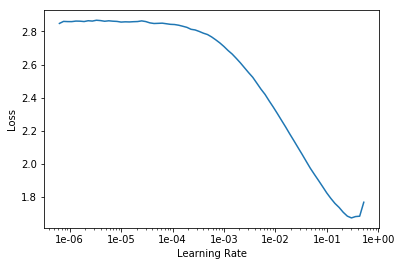

In [16]:
learn = cnn_learner(data,models.resnet18,metrics=accuracy,path='.')
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.unfreeze()
learn.fit_one_cycle(3,max_lr=slice(1e-3,1e-1))

epoch,train_loss,valid_loss,accuracy,time
0,0.536035,3.790141,0.920000,01:24
1,0.141785,0.037965,0.989048,01:24
2,0.049292,0.024332,0.994762,01:24


In [18]:
learn.save('s1')

# Fine tune

In [19]:
learn.load('s1');

In [20]:
learn.unfreeze()

In [21]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


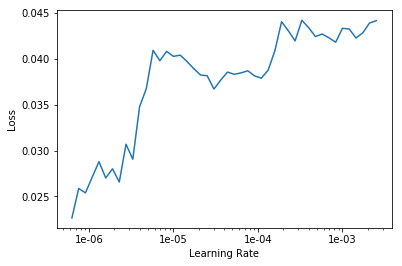

In [22]:
learn.recorder.plot()

In [23]:
learn.fit_one_cycle(3,max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy,time
0,0.042952,0.023710,0.994286,01:24
1,0.041202,0.023363,0.994286,01:22
2,0.041130,0.023787,0.994762,01:23


# Interpret results

In [24]:
interp = ClassificationInterpretation.from_learner(learn)

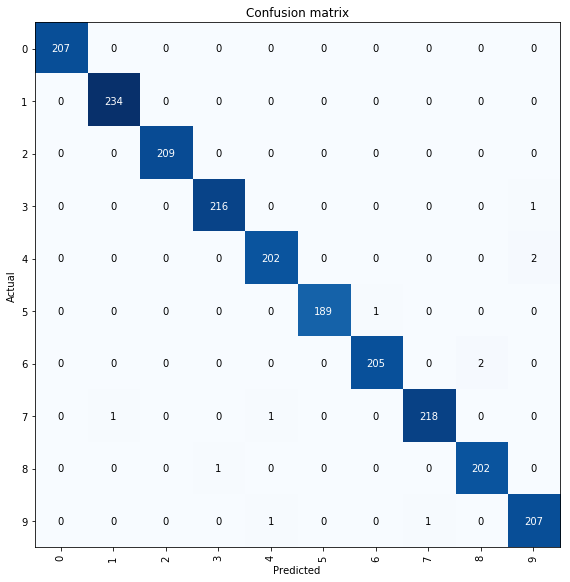

In [25]:
interp.plot_confusion_matrix(figsize=(8,8))

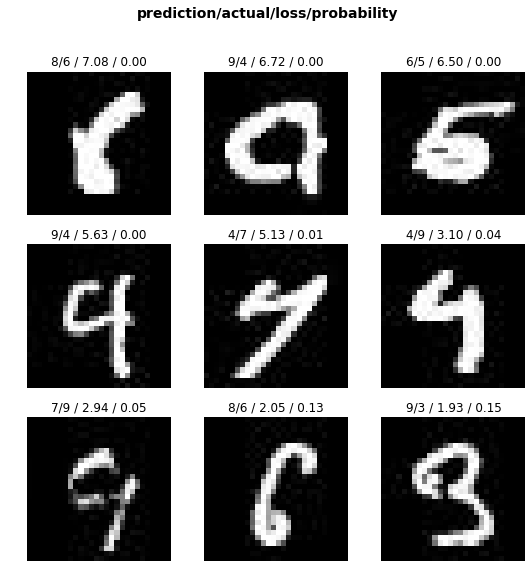

In [26]:
interp.plot_top_losses(9,figsize=(9,9))

# Make predictions

In [27]:
learn1 = learn.load('s1')
sub_df = pd.DataFrame(columns=['ImageId','Label'])

In [28]:
test_data = np.array(test_csv)

In [29]:
def get_img(data):
    t1 = data.reshape(28,28)/255
    t1 = np.stack([t1]*3,axis=0)
    img = Image(FloatTensor(t1))
    return img

In [30]:
from fastprogress import progress_bar

In [31]:
mb=progress_bar(range(test_data.shape[0]))
for i in mb:
    timg=test_data[i]
    img = get_img(timg)
    sub_df.loc[i]=[i+1,int(learn1.predict(img)[1])]

In [32]:
sub_df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [33]:
sub_df.to_csv('submission.csv',index=False)